In [1]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
import cv2
import math
import os
import numpy as np
import tensorflow as tf

classes_name=["human","static","ignore"]

#classes_name=["0","1","2"]

In [2]:
model = Sequential()

## First Block

model.add(Conv2D(8, (1, 1), input_shape=(64,64, 1)))
#model.add(Conv2D(8, (3, 3)))
model.add(LeakyReLU(alpha=0.3))
model.add(MaxPooling2D((2, 2)))

## Second Block
model.add(Conv2D(16, (1, 1)))
model.add(Conv2D(32, (1, 1)))
model.add(LeakyReLU(alpha=0.3))
model.add(MaxPooling2D((2, 2)))

## Third Block
model.add(Conv2D(32, (1, 1)))
model.add(Conv2D(64, (1, 1)))
model.add(LeakyReLU(alpha=0.3))
model.add(MaxPooling2D((2, 2)))

## Third Block
model.add(Conv2D(64, (1, 1)))
model.add(Conv2D(128, (1, 1)))
model.add(LeakyReLU(alpha=0.3))
model.add(MaxPooling2D((2, 2)))

## Forth Block
#model.add(Conv2D(16, (3, 3)))
#model.add(Conv2D(32, (3, 3)))
#model.add(LeakyReLU(alpha=0.3))
#model.add(MaxPooling2D((2, 2)))

## Fifth Block
model.add(Conv2D(64, (3, 3)))
model.add(Conv2D(32, (1, 1)))
#model.add(LeakyReLU(alpha=0.3))
#model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='linear'))

model.add(Reshape((4,4,8)))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         16        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        144       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        544       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0

In [3]:
def original_img(img_path,label_path):
    
    IMAGES = []
    
    LABELS = []
    
    img_list = os.listdir(img_path)
    
    for image_path in img_list:
        
        # Read image
        img = cv2.imread(img_path + "/" + image_path)
        #print(img_path + "/" + img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_resize = cv2.resize(gray,(64,64))
        gray_resize = np.expand_dims(gray_resize, axis=2)
        IMAGES.append(gray_resize)
        #try 3 channel
        #img = cv2.resize(img,(64,64))
        #IMAGES.append(img)
        
        # Read Labels
        label_pth = label_path + "/" + image_path.split(".")[0]+".txt"
        
        with open(label_pth) as file:
            lines = file.readlines()
            lines = [line.rstrip() for line in lines]
        
        label_matrix = np.zeros([4, 4, 8])
        
        for line in lines:
    
            #g_t = [0,0,0,0,0,0,0,0]
    
            p=line.split(" ")
    
            x = float(p[1])
            y = float(p[2])
            w = float(p[3])
            h = float(p[4])
            #g_t[4] = float(1.0)
    
            if p[0]=="0":
                cls = 0
            if p[0]=="1":
                cls = 1
            if p[0]=="2":
                cls = 2
            loc = [4 * x, 4 * y]
            loc_i = int(loc[1])
            loc_j = int(loc[0])
            y = loc[1] - loc_i
            x = loc[0] - loc_j
            #print(x,y)
            #print(w,h)

            if label_matrix[loc_i, loc_j, 7] == 0:
               label_matrix[loc_i, loc_j, cls] = 1
               label_matrix[loc_i, loc_j, 3:7] = [x, y, w, h]
               label_matrix[loc_i, loc_j, 7] = 1  # response
                
            
    
            #G_T[math.ceil(4*float(p[1]))-1,math.ceil(4*float(p[2]))-1] = g_t
        
        LABELS.append(label_matrix)
    
    return IMAGES, LABELS

In [4]:
IMAGES, LABELS = original_img("images","labels")

In [5]:
IMAGES = tf.cast(np.array(IMAGES)/255.,dtype="float32")
LABELS = tf.cast(LABELS,dtype="float32")

In [6]:
import tensorflow.keras.backend as K


def xywh2minmax(xy, wh):
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max


def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_wh = pred_maxes - pred_mins
    true_wh = true_maxes - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    return iou_scores


def yolo_head(feats):
    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = (feats[..., :2] + conv_index) / conv_dims * 64
    box_wh = feats[..., 2:4] * 64

    return box_xy, box_wh


def yolo_loss(y_true, y_pred):
    label_class = y_true[..., :3]  # ? * 4 * 4 * 3
    label_box = y_true[..., 3:4]  # ? * 4 * 4 * 4
    response_mask = y_true[..., 4]  # ? * 4 * 4
    response_mask = K.expand_dims(response_mask)  # ? * 4 * 4 * 1

    predict_class = y_pred[..., :3]  # ? * 4 * 4 * 3
    predict_trust = y_pred[..., 3:4]  # ? * 4 * 4 * 1
    predict_box = y_pred[..., 4:]  # ? * 4 * 4 * 4

    _label_box = K.reshape(label_box, [-1, 4, 4, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 4, 4, 1, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 4 * 4 * 1 * 1, ? * 4 * 4 * 1 * 1
    label_xy = K.expand_dims(label_xy, 3)  # ? * 4 * 4 * 1 * 1 * 1
    label_wh = K.expand_dims(label_wh, 3)  # ? * 4 * 4 * 1 * 1 * 1
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # ? * 4 * 4 * 1 * 1 * 1, ? * 4 * 4 * 1 * 1 * 1

    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 4 * 4 * 2 * 2, ? * 4 * 4 * 2 * 2
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 4 * 4 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 4 * 4 * 2 * 1 * 2
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # ? * 4 * 4 * 2 * 1 * 2, ? * 4 * 4 * 2 * 1 * 2

    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 4 * 4 * 2 * 1
    best_ious = K.max(iou_scores, axis=4)  # ? * 4 * 4 * 2
    best_box = K.max(best_ious, axis=3, keepdims=True)  # ? * 4 * 4 * 1

    box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 4 * 4 * 2

    no_object_loss = 0.5 * (1 - box_mask * response_mask) * K.square(0 - predict_trust)
    object_loss = box_mask * response_mask * K.square(1 - predict_trust)
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss)

    class_loss = response_mask * K.square(label_class - predict_class)
    class_loss = K.sum(class_loss)

    _label_box = K.reshape(label_box, [-1, 4, 4, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 4, 4, 1, 4])

    label_xy, label_wh = yolo_head(_label_box)  # ? * 4 * 4 * 1 * 1, ? * 4 * 4 * 1 * 1
    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 4 * 4 * 2 * 2, ? * 4 * 4 * 2 * 2

    box_mask = K.expand_dims(box_mask)
    response_mask = K.expand_dims(response_mask)

    box_loss = 5 * box_mask * response_mask * K.square((label_xy - predict_xy) / 64)
    box_loss += 5 * box_mask * response_mask * K.square((K.sqrt(label_wh) - K.sqrt(predict_wh)) / 64)
    box_loss = K.sum(box_loss)

    loss = confidence_loss + class_loss + box_loss

    return loss

In [7]:
model.compile(optimizer='adam', loss=yolo_loss)

In [8]:
history = model.fit(x=IMAGES[0:240], y=LABELS[0:240], batch_size=1, epochs=40)

Epoch 1/40
240/240 [==============================] - 8s 8ms/step - loss: 3.3026
Epoch 2/40
240/240 [==============================] - 2s 8ms/step - loss: 1.6063
Epoch 3/40
240/240 [==============================] - 2s 8ms/step - loss: 1.4371A: 0s - 
Epoch 4/40
240/240 [==============================] - 2s 8ms/step - loss: 1.3174A: 1s - los - ETA: 0s - loss:  - ETA: 0s - loss:
Epoch 5/40
240/240 [==============================] - 2s 8ms/step - loss: 1.2675
Epoch 6/40
240/240 [==============================] - 2s 8ms/step - loss: 1.2441
Epoch 7/40
240/240 [==============================] - 2s 8ms/step - loss: 1.1916
Epoch 8/40
240/240 [==============================] - 2s 8ms/step - loss: 1.1986
Epoch 9/40
240/240 [==============================] - 2s 8ms/step - loss: 1.1351
Epoch 10/40
240/240 [==============================] - 2s 8ms/step - loss: 1.0609
Epoch 11/40
240/240 [==============================] - 2s 8ms/step - loss: 1.0603
Epoch 12/40
240/240 [==============================

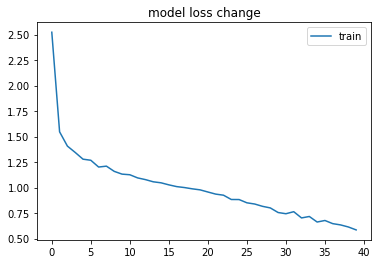

In [9]:
plt.plot(history.history['loss'], label="train")
plt.title('model loss change')
plt.legend()
plt.show()

In [10]:
def yolo_head(feats):
    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = np.shape(feats)[0:2]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = np.arange(0, stop=conv_dims[0])
    conv_width_index = np.arange(0, stop=conv_dims[1])
    conv_height_index = np.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    conv_width_index = np.tile(np.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = np.reshape(np.transpose(conv_width_index), [conv_dims[0] * conv_dims[1]])
    conv_index = np.transpose(np.stack([conv_height_index, conv_width_index]))
    conv_index = np.reshape(conv_index, [conv_dims[0], conv_dims[1], 1, 2])

    conv_dims = np.reshape(conv_dims, [1, 1, 1, 2])

    box_xy = (feats[..., :2] + conv_index) / conv_dims * 64
    box_wh = feats[..., 2:4] * 64

    return box_xy, box_wh

[[[False]
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [ True]
  [ True]]

 [[False]
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  [False]]]


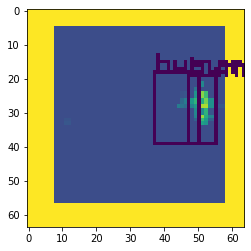

In [11]:
import cv2 as cv

prediction = model.predict(IMAGES[244:245])
prediction = np.array(prediction)

predict_class = prediction[..., :3]  # 1 * 4 * 4 * 3
predict_trust = prediction[..., 3:4]  # 1 * 4 * 4 * 1
predict_box = prediction[..., 4:]  # 1 * 4 * 4 * 4

predict_class = np.reshape(predict_class, [4, 4, 1, 3])
predict_trust = np.reshape(predict_trust, [4, 4, 1, 1])
predict_box = np.reshape(predict_box, [4, 4, 1, 4])

#print(predict_class)
#print(predict_trust)

predict_scores = predict_class * predict_trust  # 4 * 4 * 2 * 3

#print(predict_scores)

box_classes = np.argmax(predict_scores, axis=-1)  # 4 * 4 * 2
box_class_scores = np.max(predict_scores, axis=-1)  # 4 * 4 * 2
best_box_class_scores = np.max(box_class_scores, axis=-1, keepdims=True)  # 4 * 4 * 1

box_mask = box_class_scores >= best_box_class_scores  # ? * 4 * 4 * 2

filter_mask = box_class_scores >= 0.6# 4 * 4 * 2
#print(filter_mask)
filter_mask *= box_mask  # 4 * 4 * 2

filter_mask = np.expand_dims(filter_mask, axis=-1)  # 4 * 4 * 2 * 1

predict_scores *= filter_mask  # 4 * 4 * 2 * 3
predict_box *= filter_mask  # 4 * 4 * 2 * 4

box_classes = np.expand_dims(box_classes, axis=-1)
box_classes *= filter_mask  # 4 * 4 * 2 * 1

box_xy, box_wh = yolo_head(predict_box)  # 4 * 4 * 2 * 2
box_xy_min, box_xy_max = xywh2minmax(box_xy, box_wh)  # 4 * 4 * 2 * 2

predict_trust *= filter_mask  # 4 * 4 * 2 * 1
nms_mask = np.zeros_like(filter_mask)  # 4 * 4 * 2 * 1
predict_trust_max = np.max(predict_trust)
max_i = max_j = max_k = 0
while predict_trust_max > 0:
    for i in range(nms_mask.shape[0]):
        for j in range(nms_mask.shape[1]):
            for k in range(nms_mask.shape[2]):
                if predict_trust[i, j, k, 0] == predict_trust_max:
                    nms_mask[i, j, k, 0] = 1
                    filter_mask[i, j, k, 0] = 0
                    max_i = i
                    max_j = j
                    max_k = k
    for i in range(nms_mask.shape[0]):
        for j in range(nms_mask.shape[1]):
            for k in range(nms_mask.shape[2]):
                if filter_mask[i, j, k, 0] == 1:
                    iou_score = iou(box_xy_min[max_i, max_j, max_k, :],
                                    box_xy_max[max_i, max_j, max_k, :],
                                    box_xy_min[i, j, k, :],
                                    box_xy_max[i, j, k, :])
                    if iou_score > 0.2:
                        filter_mask[i, j, k, 0] = 0
    predict_trust *= filter_mask  # 4 * 4 * 2 * 1
    predict_trust_max = np.max(predict_trust) 

box_xy_min *= nms_mask
box_xy_max *= nms_mask

image = np.array(IMAGES[244])

detect_shape = filter_mask.shape

for i in range(detect_shape[0]):
    for j in range(detect_shape[1]):
        for k in range(detect_shape[2]):
            if nms_mask[i, j, k, 0]:
                cv.rectangle(image, (int(box_xy_min[i, j, k, 0]), int(box_xy_min[i, j, k, 1])),
                                (int(box_xy_max[i, j, k, 0]), int(box_xy_max[i, j, k, 1])),
                                (0, 0, 255),1)
                cv.putText(image, classes_name[box_classes[i, j, k, 0]],
                            (int(box_xy_min[i, j, k, 0]), int(box_xy_min[i, j, k, 1])),
                            1, 0.5, (0, 0, 255))

plt.imshow(image)

In [12]:
model.pop()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         16        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        144       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        544       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0

In [14]:
model.save('final_model')

INFO:tensorflow:Assets written to: final_model\assets


In [15]:
model = tf.keras.models.load_model('final_model', custom_objects={'yolo_loss': yolo_loss})

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         16        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        144       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        544       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0

In [21]:
## Make prediction code clear and smaller for STM32 C code part after prediction of 128 array

x = model.predict(IMAGES[90:91])

image = np.array(IMAGES[90])*255

for i in range(16):
    row = int(i/4)
    col = int(i%4)
    
    j=0
    index = i * 1 +j
    p_index = 3 + i * 8 +j
    scale = x[0][p_index]
    box_index = 4 + (i*2 + j)*4
    class_index = i*8
   
    box=[0,0,0,0]
    box[0] = (x[0][box_index + 0]+col)/4*64
    box[1] = (x[0][box_index + 1]+row)/4*64
    box[2] = (x[0][box_index + 2])*64
    box[3] = (x[0][box_index + 3])*64
    class_scores=[0,0,0]
    class_scores[0] = (x[0][class_index + 0])
    class_scores[1] = (x[0][class_index + 1])
    class_scores[2] = (x[0][class_index + 2])
    if scale>=0.7:

        print(classes_name[np.argmax(class_scores)])
        
        print(box)

        xy_min, xy_max = xywh2minmax(np.array(box[0:2]),np.array(box[2:4]))

        start_point = (int(xy_min[0]), int(xy_min[1]))
        print(start_point)

        end_point = (int(xy_max[0]), int(xy_max[1]))

     
        color = (255, 0, 0)

       
        thickness = 1


        image = cv2.rectangle(image, start_point, end_point, color, thickness)
            

ignore
[50.454790115356445, 30.562698364257812, 11.821660995483398, 19.398073196411133]
(44, 20)
human
[26.89631748199463, 36.717413902282715, 12.710248947143555, 22.874948501586914]
(20, 25)
static
[37.111613273620605, 50.18591380119324, 4.876895427703857, 4.169503688812256]
(34, 48)


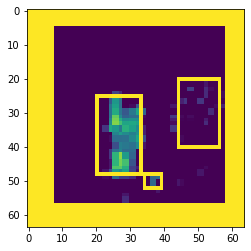

In [22]:
plt.imshow(image)

In [20]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('final_model') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('thermal_obj_detect_model.tflite', 'wb') as f:
  f.write(tflite_model)